# ANALYSE EXPLORATOIRE

1) Mettre en évidence les relations entre Nutriscore et valeurs nutritionnelles
2) Combler les valeur manquantes du nutriscore grâce à un modèle de régression linéaire sur le nutriscore
3) Faire un algorithme pour afficher un score pour le régime Cétogène en pourcentage

In [1]:
import csv
import math
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
#import tensorflow.keras
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Chemin du fichier CSV servant à l'analyse données
path = "C:\Jason\Formation OCR\Projet 2\openfoodfact_dataset_clean.csv"

dataset = pd.read_csv(path, delimiter=",").drop("Unnamed: 0", axis=1)
print("État des données:", dataset.shape)

État des données: (553665, 20)


In [3]:
dataset.columns.tolist()
dataset_vn = dataset.drop(['monounsaturated-fat_100g',
 'polyunsaturated-fat_100g',
 'omega-3-fat_100g',
 'omega-6-fat_100g',
 'omega-9-fat_100g',
 'trans-fat_100g',
 'cholesterol_100g',], axis=1)
dataset_vn["nutriscore_grade"] = dataset_vn["nutriscore_grade"].str.upper()

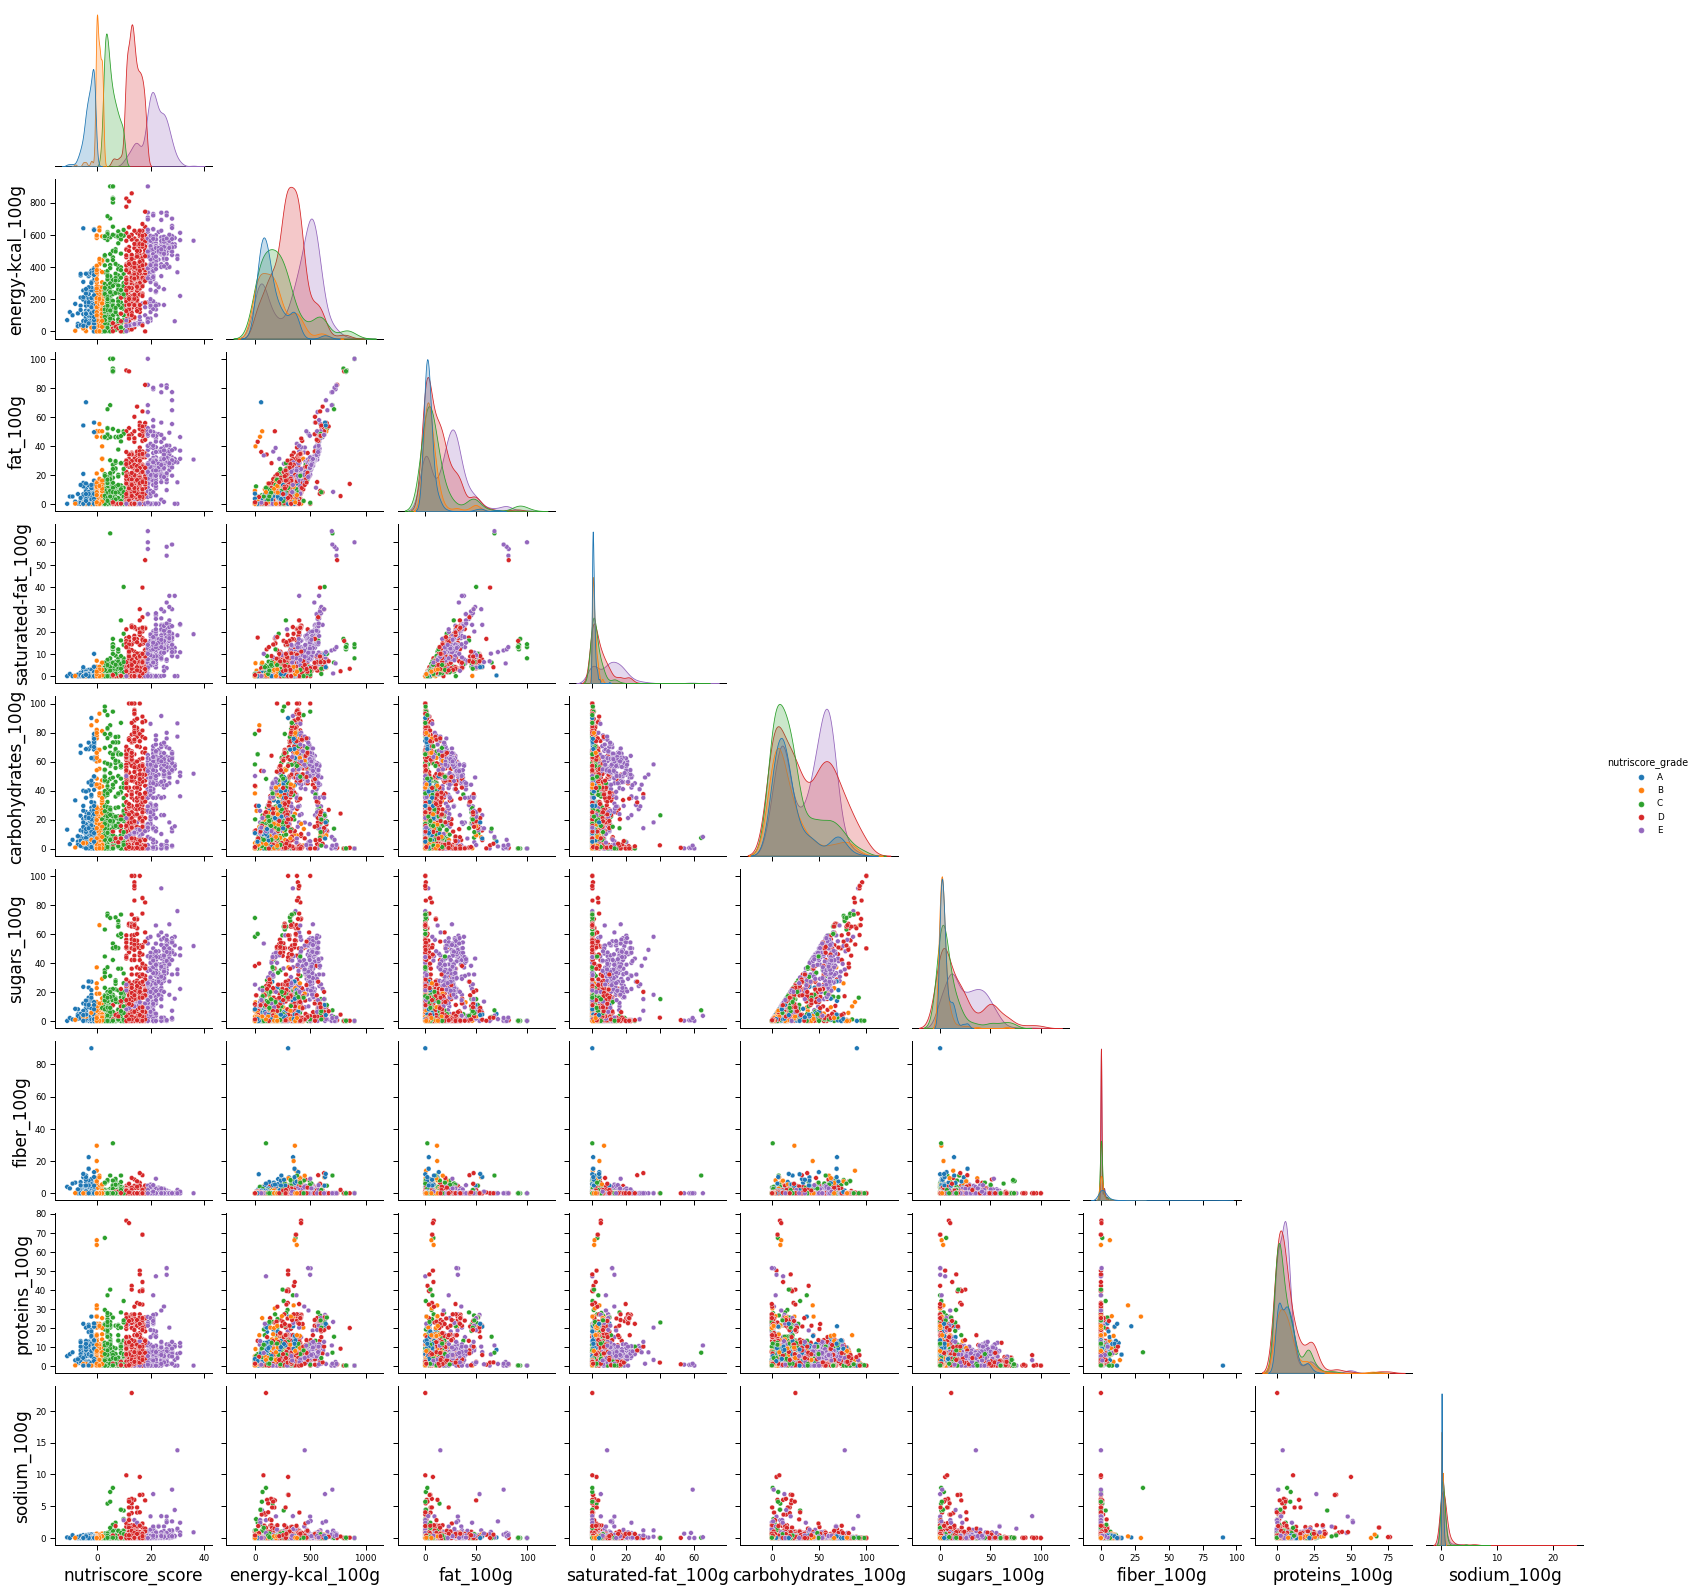

In [4]:
labels = ['A','B','C','D','E']
color= ['darkgreen', 'yellowgreen', 'gold','darkorange','orangered']
sns.set_context("paper", rc={"axes.labelsize":17})
sns.pairplot(dataset_vn.head(5000), corner=True, hue="nutriscore_grade", hue_order=['A','B','C','D','E'])
plt.savefig('graph_correlation.png')

## Matrice de corrélation

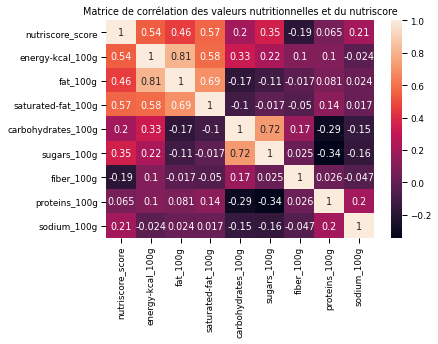

In [5]:

#df_corr = dataset_vn.drop(["code", "product_name", "image_url", "nutriscore_grade"], axis=1)
ax = plt.axes()
ax.set_title('Matrice de corrélation des valeurs nutritionnelles et du nutriscore')
sns.heatmap(dataset_vn.loc[:, ~dataset_vn.columns.isin(['product_name', 'image_url','code', 'nutriscore_grade'])].dropna().corr(), annot=True, ax=ax)
plt.savefig("matrice_correlation_nutriscore")
plt.show()

## Distribution du nutriscore_grade dans le dataset

(553665, 13)


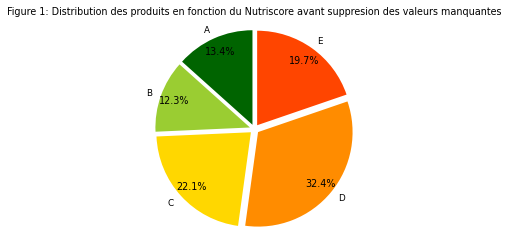

In [6]:
color= ['darkgreen', 'yellowgreen', 'gold','darkorange','orangered']
values_count_nutri = pd.value_counts(dataset_vn['nutriscore_grade']).loc[labels]
percent_nutri = values_count_nutri/values_count_nutri.sum()
print(dataset_vn.shape)


explode = (0.05,0.05,0.05,0.05,0.05)
fig1, ax1 = plt.subplots()
ax1.pie(percent_nutri, colors = color, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='black')

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
#plt.tight_layout()
plt.title("Figure 1: Distribution des produits en fonction du Nutriscore avant suppresion des valeurs manquantes")
plt.show()


Compléter les valeurs du grade nutriscore manquante grâce à une régression linéaire (on utilisera le score du nutriscore puis il sera converti en grade)

['code', 'product_name', 'image_url', 'nutriscore_score', 'nutriscore_grade', 'energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g']


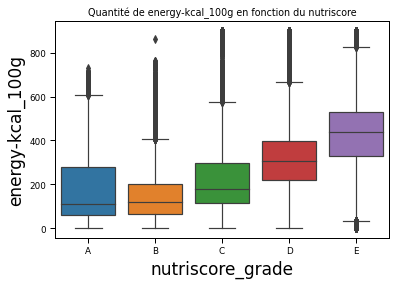

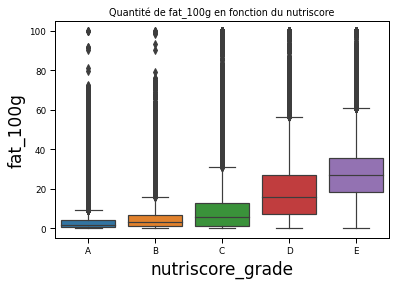

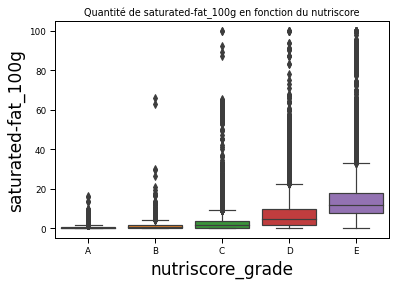

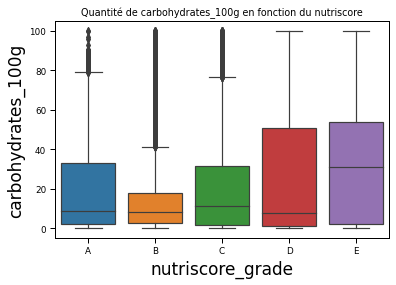

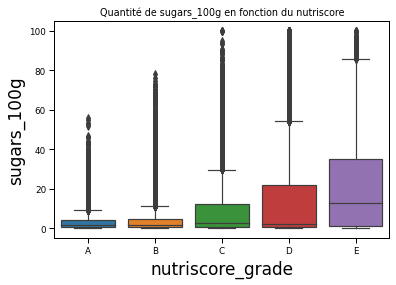

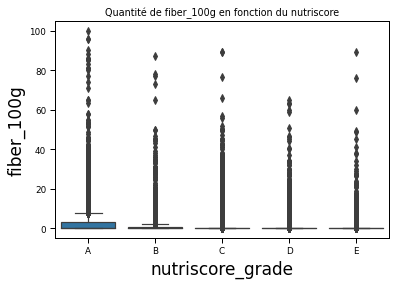

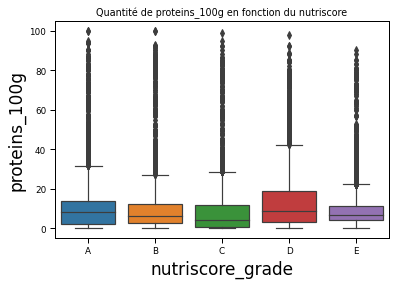

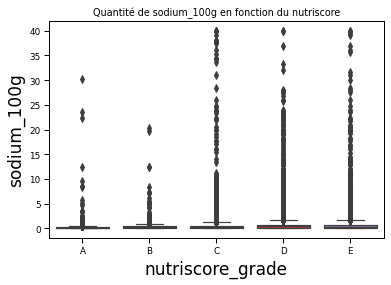

In [7]:
print(dataset_vn.columns.tolist())
for name in dataset_vn.columns.tolist():
    if "_100g" in name:
        plt.figure()
        plt.title(f"Quantité de {name} en fonction du nutriscore")
        sns.boxplot(x=dataset_vn["nutriscore_grade"], y=dataset_vn[name], order=labels)

### Remarque :
    1) sugar_100g, saturated-fat_100g, fat_100g, sodium_100g plus il y en a moins bon est le nutriscore.
    

In [8]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd

# fonction source openclassroon cours réaliser une analyse exploratoire
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10,10))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
n_comp = 2
scaler = StandardScaler()
pca = PCA(n_components=n_comp)

data = dataset_vn[["nutriscore_score", 'energy-kcal_100g', "saturated-fat_100g", "fat_100g","sugars_100g", "carbohydrates_100g",
                'proteins_100g', 'sodium_100g', "fiber_100g"]].dropna()

X = data.values
features = data.columns
X_scaled = scaler.fit_transform(X)
pca_components = pca.fit_transform(X_scaled)
pcs = pca.components_

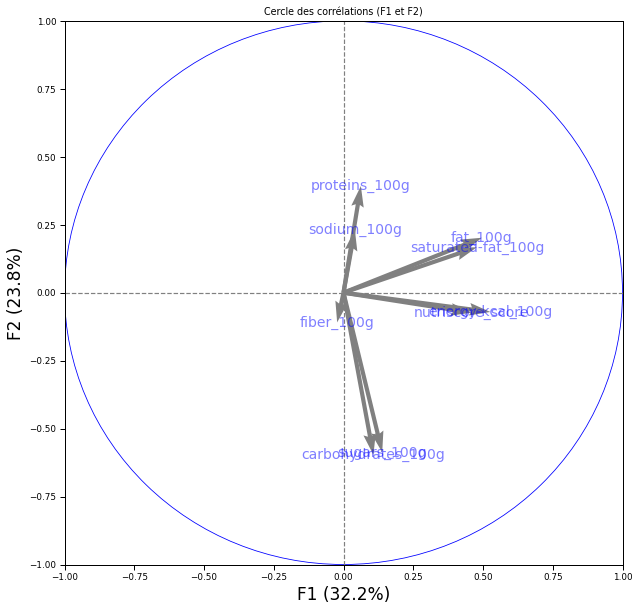

In [10]:
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

F1 (32.2%): fat_100g, saturated-fat_100g, energy-kcal_100g, nutriscore_score
F2 (23.8%): carbohydrates_100g, sugars_100g, proteins_100g

## Remplissage des valeurs manquantes pour le nutriscore par régression linéaire

In [11]:
# On filtre les colonnes du dataset et on supprime les Nan.
dataset.head()
df = dataset.drop(["code", "product_name", "image_url", "nutriscore_grade"], axis=1)
print(df.shape)
df = df.dropna()
print(df.shape)
X = df.drop(["nutriscore_score"], axis=1)
y = df["nutriscore_score"]

# Normalisation de nos donnée
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
std = StandardScaler()
robust = RobustScaler()
minmax = MinMaxScaler()

# RobustScaler donne les meilleurs résultats.
X_std = robust.fit_transform(X)
print(X_std.shape[1])


(553665, 16)
(237876, 16)
15


In [12]:
# Séparation du dataset en deux,  un pour apprentissage(_train) et un pour valider notre modèle (_test)
X_train, X_test, y_train, y_test = train_test_split(X_std, y, random_state=1, test_size=0.6)


In [ ]:
regr = MLPRegressor(random_state=1, max_iter=1500, verbose=0, hidden_layer_sizes=(X_std.shape[1]*2, 50)).fit(X_train, y_train)

In [ ]:
print(np.shape(X_test))
prediction = regr.predict(X_test)

In [ ]:
score = regr.score(X_test, y_test)
print("r2 :", round(score*100, 2),"%")

In [ ]:
length = 20000
a,b = np.polyfit(y_test,prediction,1)
r2 = round(np.corrcoef(y_test,prediction)[0,1]**2,4)
print("r2 :", r2*100,"%")
plt.figure(figsize=(10, 10))
plt.plot(y_test,(a*y_test+b),label='linear regression')
plt.plot(y_test[:length], prediction[:length],'ro', markersize=1)
#plt.scatter(y_test[:length], prediction[:length])
plt.xlabel("Valeur prédite")
plt.ylabel("Valeur réelle")
plt.show()

In [ ]:
df_result = pd.DataFrame()
df_result["prediction"] = prediction.round()
print(type(y_test))
print(type(prediction))
df_result["y_test"] = np.array(y_test)
df_result["erreur_abs"] = (df_result["prediction"] - df_result["y_test"]).abs()

df_result.head(10)

In [ ]:
df_result.describe(percentiles=[0.25, 0.5, 0.75, 0.90, 0.95])

In [ ]:
dataset_vn.head(10)
dataset.columns.tolist()

In [ ]:
def prediction_nutriscore(df, model, std):
    X = df.copy() 
    colonne = ['energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'omega-3-fat_100g', 'omega-6-fat_100g', 
               'omega-9-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g']
    #colonne = ['energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g']
    X[colonne] = std.fit_transform(X[colonne])
    #data = X.drop(['product_name', 'image_url','code', 'nutriscore_grade'], axis=1).loc[i]
    pred = regr.predict(X[colonne]).round()
    
    df["nutriscore_score_pred"] = pred
    return df

df_final = prediction_nutriscore(dataset, regr, robust)



In [ ]:

df_final["erreur_pred_abs"] = (df_final["nutriscore_score"] - df_final["nutriscore_score_pred"]).abs()
print("Aperçu des prédiction")
df_final[~df_final['nutriscore_score'].isnull()][["nutriscore_score", "nutriscore_score_pred", "erreur_pred_abs"]].head(10)

In [ ]:
print("Tableau résumé des prédictions sur l'échantillon")
df_final[~df_final['nutriscore_score'].isnull()][["nutriscore_score", "nutriscore_score_pred", "erreur_pred_abs"]].describe(percentiles=[0.25, 0.5, 0.90, 0.95])

In [ ]:
df_final.head(10)

In [ ]:
# On remplace les Nan valeur du nutriscore_score par le le nutriscore_score_pred seulement pour les Nan du nutriscore_score
df_final["nutriscore_score"].fillna(df_final["nutriscore_score_pred"], inplace=True)
df_final.head()
msno.matrix(df_final)

In [ ]:
# On remplace les nan du nutriscore_grade grâce au nouveau nutriscore_score
"""Valeur nutriscore : Les résultats du calcul donnent une valeur comprise entre –15 et +40. 
La couleur verte correspondant à une valeur comprise entre –15 et –2, le vert clair de –1 à +3, le jaune de +4 à +11, l'orange de +12 à +16 et le rouge de +17 à +40
A : -15 à -2
B : -1 à 3
C : 4 à 11
D : 12 à 16
E : 17 à 40"""
df_final = df_final.astype({"nutriscore_grade" : "string"})

df_final.loc[(df_final['nutriscore_score'] >= -15) & (df_final['nutriscore_score'] <= -2), "nutriscore_grade"] = "A"
df_final.loc[(df_final['nutriscore_score'] >= -1) & (df_final['nutriscore_score'] <= 3), "nutriscore_grade"] = "B"
df_final.loc[(df_final['nutriscore_score'] >= 4) & (df_final['nutriscore_score'] <= 11), "nutriscore_grade"] = "C"
df_final.loc[(df_final['nutriscore_score'] >= 12) & (df_final['nutriscore_score'] <= 16), "nutriscore_grade"] = "D"
df_final.loc[(df_final['nutriscore_score'] >= 17) & (df_final['nutriscore_score'] <= 40), "nutriscore_grade"] = "E"




In [ ]:
def remove_aberant(df, variable,minimum, maximum):

    data_cleaned = df.copy()
    
    for name in variable:
        if name in data_cleaned.columns.tolist():
            data_cleaned = data_cleaned.query(f'`{name}` <= {maximum}')
            data_cleaned = data_cleaned.query(f'`{name}`>= {minimum}')
            
    return data_cleaned
df = remove_aberant(df_final, ["nutriscore_score"], -15, 40)
df = df.drop(["nutriscore_score_pred", "erreur_pred_abs"], axis=1)
df.describe()

In [ ]:
msno.matrix(df)
print("Selon le tableau ci dessous, il manque des valeurs uniquement pour les variables product_name et image_url")

In [ ]:
color= ['darkgreen', 'yellowgreen', 'gold','darkorange','orangered']
values_count_nutri_apres = pd.value_counts(df['nutriscore_grade']).loc[labels]
percent_nutri_apres = values_count_nutri_apres/values_count_nutri_apres.sum()
print(df.shape)


explode = (0.05,0.05,0.05,0.05,0.05)
fig1, ax1 = plt.subplots()
ax1.pie(percent_nutri_apres, colors = color, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='black')
#fig1.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
#plt.tight_layout()
plt.title("Figure 1: Distribution des produits en fonction du Nutriscore avant suppresion des valeurs manquantes")
plt.show()

# Alogrithme du régime Cétogène
    Répartition de la valeur nutritionnelle par produit 
        - 90% de lipides (fat_100g)
        - 8% protéines (proteins_100g)
        - 2% glucides (carbohydrates_100g)
    But du régime:
        Obliger le corps à fournir la majeur partie de son énergie par les lipides, donc fournir un minimum d'apport en protéine mais surtout en glucide.
        indice vert : Le produit contient moins de 2% de glucide
        indice orange :  Le produit contient mois de 10% de glucide et moins de 20% de protéines
        indice rouge : Tous les produits restant

In [ ]:
from IPython.display import Image
import random


def regime_keto(df, code):
    data = df.query(f"code == '{code}'")
    
    interdit = "C:\Jason\Formation OCR\Projet 2\Interdit.png"
    deconseille = "C:\Jason\Formation OCR\Projet 2\Déconseillé.png"
    excellent = "C:\Jason\Formation OCR\Projet 2\Excellent.png"
    
    fat = data["fat_100g"].tolist()[0]
    carbs = data["carbohydrates_100g"].tolist()[0]
    prots = data["proteins_100g"].tolist()[0]
    image_url = data["image_url"].tolist()[0]
    product_name = data["product_name"].tolist()[0]
    #print("fat :", fat/100)
    #print("carbs :", carbs/100)
    #print("prots :", prots/100)
    #score = fat/100 - carbs/100 -  prots/100
    #print("score :", score )
    #print("keto_score :", 1 - score)
    keto_score = (1 - ((fat/100) - (carbs/100) - (prots/100)))*100
    #print("keto_score =", keto_score)
    
    if data["carbohydrates_100g"].tolist()[0] <= 2:
        #print("Indicateur Keto : C'est vert")
        display(Image(excellent, width=400, height=400))
    elif data["proteins_100g"].tolist()[0] <= 20 and data["carbohydrates_100g"].tolist()[0] <=10 :
        #print("Indicateur Keto : c'est orange")
        display(Image(deconseille, width=400, height=400))
    else:
        #print("Indicateur Keto : c'est rouge")
        display(Image(interdit, width=400, height=400))
    print(f"Le produit : {product_name}")    
    
    try:
        display(Image(url= image_url, width=400, height=400))
    except:
        print("Aucune image disponible pour le produit")
        
    return keto_score, product_name, image_url

df = df.astype({"code" : "string"})
code_barre = df["code"].tolist()
random_index = random.randrange(len(code_barre))
print("code_barre:", code_barre[random_index])
keto_score, product, image_url = regime_keto(df, code_barre[random_index])
#keto_score, product, image_url = regime_keto(df, 5060092690461)


Limite de l'indice : Il vaut mieux regarder un menu complet plutôt que produit par produit lors d'un repas.